# Intelligent Scale Reading

The purpose of this is to take in an image captured via iPhone camera and determine what the weight displayed on the scale is.  This will then be passed down the pipeline to record and perform analytics on.


In [1]:
VERSION = "5"

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
torch.cuda.set_device(0)

import cv2

In [4]:
PATH = "/src/data/digits/"

### (Didn't work): Retrieiving Digit Images to Train on

First step is to build the data library for the model to learn the digits 0-9 and be able to identify them in photos.  We'll use the google_images_download (which we have already installed chromedriver.exe for) to retrieve our training data.

In [ ]:
from google_images_download import google_images_download as gi

response = gi.googleimagesdownload()
#Let's try out one digit to make sure our retrieval method is working properly. 
## Pass in the various arguments here - note they will be downloaded to download folder 
# they will need to be moved to the proper training spots

arguments = {
    "keywords" : "the number six", 
    "limit" : 100, 
    "print_urls" : False, 
    "chromedriver" : "E:\\chromedriver.exe"
} 

paths = response.download(arguments)
# Clear this output before printing

#Now that we know that one works, we'll download the rest of the digits in the same way.

digits_list = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight','nine'];
for digit in digits_list:
    arguments['keywords'] = 'the number ' + str(digit)
    paths = response.download(arguments)

# Then we'll have to manually clean the data, then move it to /src/data/digits.  From there, we'll manually split up into training and test data (after we've cleaned up the wrong files as well).

### Build the validation set

digits_list = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight','nine'];
for digit in digits_list:
    arguments['keywords'] = 'number ' + str(digit) + " clipart"
    paths = response.download(arguments)

## Step 1: Building a Number digit Generator

So that failed miserably - it will take way too long to download and curate all of those images.  Probably the best thing to do is build some kind of data generated that creates images with various transformations in various fonts.

List of transforms we want:
    - Massive scaling discrepancies (between 0.1 and 2.5)
    - Rotations all about - probably between 0-90
    - Brightness and contrast moved about between 0-50 %
    - Definitely want some kind of noise applied as well
    - Different background colours

Fonts we want to use:
    - Emphasis on the LED fonts
    - Can use other ones as well though
    
Number of examples we want to generate:
    - 2000 a piece

In [10]:
img = np.zeros((512,512,3), np.uint8)

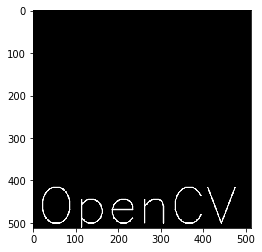

In [11]:
font = cv2.FONT_HERSHEY_SIMPLEX
output = cv2.putText(img,'OpenCV',(10,500), font, 4,(255,255,255),2,cv2.LINE_AA)
plt.imshow(output)

In [12]:
from PIL import ImageFont, ImageDraw, Image

In [13]:
img = np.zeros((200,200,3),np.uint8)
b,g,r,a = 0,255,255,0
fontpath = "/src/data/digits/fonts/"
font_size=64
x_pos = 10
y_pos = 100

In [14]:
digit = 4

 - We downloaded a bunch of LED type fonts, since that's what we'll be using for the scale
 - https://www.dafont.com/theme.php?cat=302

In [15]:
font = ImageFont.truetype(fontpath + "alarm clock.ttf", font_size)
img_pil = Image.fromarray(img)
draw = ImageDraw.Draw(img_pil)
draw.text((x_pos, y_pos),  str(digit), font = font, fill = (b, g, r, a))
img = np.array(img_pil)

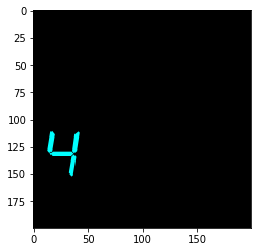

In [16]:
plt.imshow(img)

In [ ]:
plt.imsave("/src/data/digits/4.jpg", img)

### Create Images

In [6]:
from PIL import ImageFont, ImageDraw, Image
img = np.zeros((200,200,3),np.uint8)
fontpath = "/src/data/digits/fonts/"


In [7]:
ttfs_array = os.listdir(fontpath); ttfs_array

['alarm clock.ttf',
 'Calculator.ttf',
 'digital-7 (italic).ttf',
 'digital-7 (mono italic).ttf',
 'digital-7 (mono).ttf',
 'digital-7.ttf',
 'DJB Get Digital.ttf',
 'Open 24 Display St.ttf',
 'Technology-Bold.ttf',
 'Technology-BoldItalic.ttf',
 'Technology-Italic.ttf',
 'Technology.ttf']

In [8]:
def rotateImage(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output


def generate_image(digit):
    '''
    Generates the image
    '''
    img = np.zeros((500,500,3),np.uint8)
    
    r,g,b = img.T
    
    # This is the background color
    g[g == 0] = random.randint(150,255)
    g[random.randint(0,200):random.randint(200,500)] = random.randint(150,255)
    r[r == 0] = random.randint(150,255)
    r[random.randint(0,200):random.randint(200,500)] = random.randint(150,255)
    b[b == 0] = random.randint(0,10)
    b[random.randint(0,200):random.randint(200,500)] = random.randint(0,10)
    
    
    font_size = random.randint(120,180)
    font = ImageFont.truetype(fontpath + ttfs_array[random.randint(0,len(ttfs_array)-1)], 
                              size=font_size)
    
    img_pil = Image.fromarray(img)
    
    draw = ImageDraw.Draw(img_pil)
    
    # This is the font colour
    b = random.randint(0,100)
    g = random.randint(0,100)
    r = random.randint(0,100)
    a = random.randint(0,30)
    
    x_pos = random.randint(100,200) - font_size/2
    y_pos = random.randint(100,200) - font_size/2
    
    draw.text((x_pos, y_pos),  str(digit), font = font, fill = (b, g, r, a))
    img = np.array(img_pil)
    img = rotateImage(img, random.randint(-60,60))
    
    # Added in some Gaussian Blur
    img = cv2.GaussianBlur(img,(random.randint(1,11)*2+1,random.randint(1,11)*2+1),0)
    
    if(random.randint(1,10) > 4):
        img = sp_noise(img, 0.05)
    #img = cv2.medianBlur(img,5)
    return img


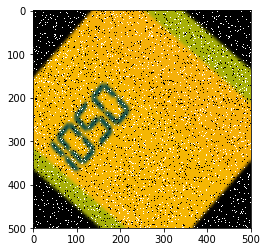

In [9]:
img = generate_image(1050)
plt.imshow(img)

In [ ]:
'''
generated_digits = {
    "1" : "one",
    "2" : "two",
    "3" : "three",
    "4" : "four",
    "5" : "five",
    "6" : "six",
    "7" : "seven",
    "8" : "eight",
    "9" : "nine",
    "0" : "zero"
}
'''
# We have changed this function substantially, when we have changed our approach
'''
def generate_images(save_path, total_number):
    for digit in generated_digits.keys():
        count = 0
        for i in range(0,total_number):
            img = generate_image(digit)
            plt.imsave(save_path + generated_digits[digit] + "_" + str(count) + ".jpg", img)
            
            count += 1
        print ("Finished with " + str(digit))

'''

# This is the new function that we are generating for our regression attempt

In [ ]:
from ipywidgets import IntProgress
from IPython.display import display
import time

In [18]:
generated_count = 200

In [ ]:
def generate_images(save_path):
    
    max_count = 2500
    min_count = 1000
    
    f = IntProgress(min=0, max=(max_count-min_count), description="Generating: ") # instantiate the bar
    display(f) # display the bar
    csv_output = "fn,val\r\n"
    for i in range(min_count,max_count):
        count = 0
        for j in range(0,generated_count): # TODO: Change this to larger once proven
            img = generate_image(i)
            plt.imsave(save_path + str(i) + "_" + str(count) + ".jpg", img)
            #csv_output += save_path + str(i) + "_" + str(count) + ".jpg" + "," + str(i) + "\r\n" 
            csv_output += save_path + str(i) + "_" + str(count) + ".jpg" + ","  
            csv_output += str(i)[0] + " " + str(i)[1] + " " + str(i)[2] +  " " + str(i)[3] + "\r\n" 
             
            count += 1
        f.value += 1
            
        #print ("Finished for " + str(i))
    f = open(save_path + "regression.csv",'w')
    f.write(csv_output)
    f.close()
    print ("Finished writing")


Many images generation time - this takes a VERY long time.

In [ ]:
save_path = "/src/data/digits/regression/"
generate_images(save_path)

## Step 2 - Regression model

Our first attempt was to train a multiclass classifier to identify the digits.  It did okay at that, but started to get confused.  Then I realized, why not train it to do the thing I actually want it to do - regression.

So instead of teaching it to recognize digits (which it did okay at), I want to try a regression model to actually learn something of value

--------------

In [19]:
#f_model=resnet34
f_model = resnet18
sz=224  
bs=64 # Changed from 64 - will try 128
n = 1500 * generated_count # Number of entries we have now

In [20]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.NO)


In [21]:
pd.read_csv(PATH + "/regression_newer.csv").head()

,fn,val
0,1000_0,1 0 0 0
1,1000_1,1 0 0 0
2,1000_2,1 0 0 0
3,1000_3,1 0 0 0
4,1000_4,1 0 0 0


We're going to move all of the \_0.jpg files out to test and then modify the csv file

In [22]:
val_idx = get_cv_idxs(n)

We'll want to work with the transforms at a later date

In [23]:
md = ImageClassifierData.from_csv(PATH, 
                                  "regression/", 
                                  PATH + "/regression_newer.csv", 
                                  tfms=tfms, 
                                  suffix = ".jpg",
                                  # test_name = "test", # This I believe is only for TTA 
                                  val_idxs=val_idx,
                                  continuous=True, 
                                  skip_header = True,
                                  bs=bs)

# We really ought to consider doing a test folder

In [24]:
class MSELossFlat(nn.MSELoss): 
    '''
    Same as `nn.MSELoss`, but flattens input and target.
    This proved extremely valuable since I want to minimize the loss of ALL entries
    Maybe I should have weighted the left most digit as 100x more important...
    '''
    def forward(self, input, target):
        return super().forward(input.view(-1), target.view(-1))

In [25]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))  # What is this 25088 thing here? 112 * 224
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam # Is Adam the proper optimizer here?
#learn.crit = nn.L1Loss() # TODO - Not convinced L1 Loss is the best here - maybe L2 or MSE?
learn.crit = MSELossFlat() # Changing over to MSE, then MSELossFlat which flattens (better for what I want)

Need to modify this architecture, since we're trying regression instead of classification

In [26]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', tensor(9408))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', tensor(128))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape

In [27]:
learn.data.is_reg()

True

In [28]:
torch.cuda.set_device(0)

 34%|███▍      | 1289/3750 [34:57<2:32:02,  3.71s/it, loss=24.4]

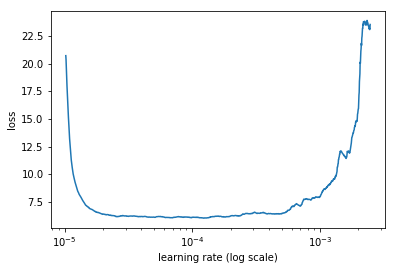

In [29]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

This seems a good value given the graph above (right in the middle before it starts increasing wildly).

In [30]:
lr = 3e-4

In [31]:
learn.unfreeze() # This may or may not be a good idea

In [32]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                      
    0      0.065641   0.053871  
    1      0.053848   0.072309                                      
    2      0.023318   0.020639                                      


[0.02063905619382858]

In [33]:
learn.save("regression-1" + VERSION)

In [34]:
learn.load("regression-1" + VERSION)

----------------------
## Given the amount of data we have, the next steps are probably unnecessary

I am actually wrong here.  I haven't taught a very good deep model - I've just taught the (granted massive) training set.  What I actually need is a good model, not just good accuracies/loss.

I was led astray by the good accuracies/loss, but in reality, I had only trained the lower layers (and probably overfit - even on validation).

I think there's a real chance I'm trying to be too cute - this isn't a terribly difficult task to be honest.  Probably just throwing a standard learner with a standard learning rate would work well here.

In [ ]:
lrs = np.array([lr/10,lr,lr*2])

In [ ]:
learn.freeze_to(-2)

In [ ]:
lrf=learn.lr_find(lrs)
learn.sched.plot(1)

In [ ]:
learn.fit(lrs, 5, cycle_len=1)

In [ ]:
learn.save("regression-2-a" + VERSION)

In [ ]:
learn.load("regression-2-a" + VERSION)

In [ ]:
learn.freeze_to(-6)

In [ ]:
learn.fit(lrs, 5, cycle_len=1)

In [ ]:
learn.save("regression-3" + VERSION)

In [ ]:
learn.load("regression-3" + VERSION)

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit(lrs, 5, cycle_len=2)

In [ ]:
learn.save("regression-4" + VERSION)

In [ ]:
learn.load("regression-4" + VERSION)

### Spot check to make sure all is well

In [43]:
x,y = md.val_dl.get_batch([0,1,2])

In [44]:
#x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

In [47]:
pred = random.randint(1,3)

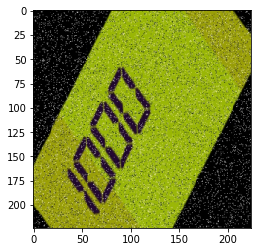

In [48]:
plt.imshow(md.val_ds.denorm(to_np(x))[pred])

In [49]:
preds[pred]

array([1.0359 , 0.04464, 0.12112, 0.00726], dtype=float32)

In [50]:
[round(float(preds[pred][i])) for i in range(0,4)]

[1, 0, 0, 0]

So our model seems to be predicting that reasonably well (after rounding).  On to some real data!

## Step 3: Trying on a real photo

This is the heatmap (probably more of a bounding box)

Other thoughts - we'll want to count the number of occurrences.  If the photo given doesn't have enough matches, then we want to return an error

In [51]:
test_fname = PATH + "photo2.jpg"
#test_fname = PATH + "photo.jpg"
output_fname = "output.jpg"

In [52]:
def custom_process(test_fname, output_fname):
    '''
    Masks and attempts to find the scale reading
    '''
    
    #Image.open(PATH + test_fname).resize((500, 500))
    im = open_image(test_fname)
    import imageio
    frame = imageio.imread(test_fname)
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    lower_red = np.array([10,0,0])
    upper_red = np.array([38,255,255])
    mask = cv2.inRange(hsv, lower_red, upper_red)
    res = cv2.bitwise_and(frame,frame, mask= mask)
    plt.imshow(res)
    #plt.imsave(output_fname,res)
    return res

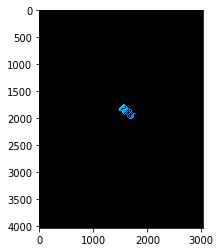

In [53]:
img = custom_process(test_fname, output_fname)

In [54]:
plt.imsave(output_fname,img)

## Crop to make life easier
We want to try autocropping this.

In [55]:
input_fname = "output.jpg"
output_fname = "output.jpg"

In [56]:
def crop_image(img,tol=10):
        # img is image data
        # tol  is tolerance
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]

In [57]:
def custom_process_stage_two(input_fname, output_fname):
    '''
    Handles autocrop of the image and final save
    '''
    padding = 75
    
    
    image = cv2.imread(input_fname)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    #edged = cv2.Canny(blurred, 50, 200, 255)
    #cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
    #    cv2.CHAIN_APPROX_SIMPLE)

    #plt.imshow(edged)

    img = cv2.imread(input_fname)
    
    #plt.imshow(img)

    #mask = blurred > 0

    # Coordinates of non-black pixels.
    #coords = np.argwhere(mask)

    # Bounding box of non-black pixels.
    #x0, y0 = coords.min(axis=0)
    #x1, y1 = coords.max(axis=0) + 1  

    #x0,x1,y0,y1

    
    #x_mean = (x0+x1)/2
    #y_mean = (y0+y1)/2

  
    y_mean,x_mean = cv2.findNonZero(gray).mean(axis=0)[0]
    x_min = int(x_mean - (sz/2)) - padding
    x_max = x_min + sz + (2*padding)

    y_min = int(y_mean - (sz/2)) - padding
    y_max = y_min + sz + (2*padding)

    print((x_min,x_max),(y_min,y_max))

    #img2 = (blurred[x_min:x_max,y_min:y_max])
    img2 = (gray[x_min:x_max,y_min:y_max])
    #img2.shape

    # Manual code - want to get away from this
    #img2 = edged[600:824,400:624]

    #plt.imshow(img2)
    #img2 = img

    #brightness = 40
    #contrast = 127
    #img2 = np.int16(img2)
    #img2 = img2 * (contrast/127+1) - contrast + brightness
    #img2 = np.clip(img2, 0, 255)
    #img2 = np.uint8(img2)



    #plt.imshow(img2)

    #plt.imsave(output_fname, img2)
    return img2


In [58]:
img2 = custom_process_stage_two(input_fname, output_fname)

(1691, 2065) (1435, 1809)


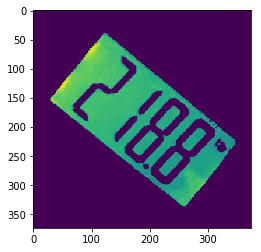

In [59]:
plt.imshow(img2)

In [60]:
plt.imsave(output_fname, img2)

### Time to find our prediction!

In [61]:
val_tfms=tfms[1]; val_tfms

[<fastai.transforms.Scale object at 0x0000027B7BFEB940>, <fastai.transforms.NoCrop object at 0x0000027B7BFEB908>, <fastai.transforms.Normalize object at 0x0000027B7BFEB860>, <fastai.transforms.ChannelOrder object at 0x0000027B7BFEBBE0>]

In [62]:
test_path = "/src/data/digits/regression/1321_30.jpg"
test_path = "output.jpg"
im = open_image(test_path) # open_image() returns numpy.ndarray
#im = cv2.flip(im, 1)
#im = cv2.rotate(im, cv2.ROTATE_90_COUNTERCLOCKWISE)
#im = cv2.normalize(im, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
im = val_tfms(im)
#im = im.T


In [63]:

preds = learn.predict_array(im[None]);preds

array([[ 1.62582,  1.41848, -0.40032,  0.74501]], dtype=float32)

In [64]:
im.T.shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


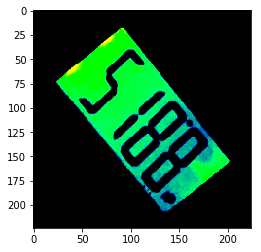

In [65]:
plt.imshow(im.T)

In [66]:
temp_preds = [round(float(preds[0][i])) for i in range(3,-1,-1)]
temp_preds.reverse()
temp_preds

[2, 1, 0, 1]

## Step 4 : Building a small dataset to train on 

What I think we've ended up doing is creating a nice opportunity for transfer learning.

I think from here, I need to have 20-100 labelled photos from the actual scale and only train (unfreeze) the last couple of layers.  Maybe just the last 1?

I think I'm going to take a video and pull frames from there.  Need to also create pipeline functions for processing the photos down

### Code used to decode the video
```
ffmpeg -i *.mp4  output_%04d.jpg
```

Here's an interesting thought - I think the model will tend to predict 1s or 2s since it's seen the most of those.  I probably need to build the set going from 0000 - 9999 to have all digits equally trained.  I'll try this if I get in trouble on the real dataset + transfer learning.

### Need to convert the small live dataset

We need to autocrop and process.

- Need to run the process and process 2 step on all of the files, overwrite
- custom_process and custom_process_stage_two

In [ ]:
rotated_path = "/src/data/digits/rotated/"

In [ ]:
# ONLY RUN THIS CODE ONCE
for fname_temp in os.listdir(rotated_path):
    if ".jpg" in fname_temp:
        fname = rotated_path + fname_temp.split("/")[-1]
        print(fname)
        img = custom_process(fname, fname)
        plt.imsave(fname, img)
        img2 = custom_process_stage_two(fname, fname)
        plt.imsave(fname, img2)

## Step 5 : Weights transfer and Training on the small dataset

We want to create a new learner with the same architecture, etc and then transfer over the weights using ```state_dict()``` and ```load_stat_dict``` from ```learn.model```

In [67]:
temp_model = learn.model

### Time to recreate the model

In [70]:
csv_fname = "/rotated/labels_rotated_x10.csv"

In [71]:
f_model=resnet18
sz=224  
bs=3 # Changed from 64 - will try
#n = 1500 * generated_count # Number of entries we have now
n = len(pd.read_csv(PATH + csv_fname))
n

336

In [72]:
PATH

'/src/data/digits/'

This csv contains the 30-40 odd examples that have been duplicated 10 times (in the csv only)

In [73]:
aug_tfms = [
        AddPadding(pad=30, mode=cv2.BORDER_REPLICATE),
        RandomRotateZoom(deg=60, zoom=1.2, stretch=1.1),
        RandomLighting(0.05,0.05)]

In [74]:
tfms = tfms_from_model(f_model, 
                       sz,
                       aug_tfms = aug_tfms,
                       crop_type=CropType.NO,
                       max_zoom = 1.1,
                       tfm_y=TfmType.NO)


In [75]:
pd.read_csv(PATH + csv_fname).head()

,fn,val
0,/src/data/digits/rotated/1022.jpg,1 0 2 2
1,/src/data/digits/rotated/1066.jpg,1 0 6 6
2,/src/data/digits/rotated/1078.jpg,1 0 7 8
3,/src/data/digits/rotated/1106.jpg,1 1 0 6
4,/src/data/digits/rotated/1108.jpg,1 1 0 8


In [76]:
val_idx = get_cv_idxs(n, val_pct=0.3)

In [77]:
md = ImageClassifierData.from_csv(PATH, 
                                  "rotated", 
                                  PATH + csv_fname, 
                                  tfms=tfms, 
                                  val_idxs=val_idx,
                                  continuous=True, 
                                  skip_header = True,
                                  bs=bs)

# We really ought to consider doing a test folder

In [78]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))  # What is this 25088 thing here? 112 * 224
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam # Is Adam the proper optimizer here?
#learn.crit = nn.L1Loss() # TODO - Not convinced L1 Loss is the best here - maybe L2 or MSE?
learn.crit = MSELossFlat() # Changing over to MSE, then MSELossFlat which flattens (better for what I want)

### Time for the transfer

Make sure we have different models

In [79]:
temp_model.state_dict()['8.1.weight'][0][0]

tensor(-0.0055, device='cuda:0')

In [80]:
learn.model.state_dict()['8.1.weight'][0][0]

tensor(-0.0047, device='cuda:0')

Then for the transfer

In [81]:
learn.model.load_state_dict(temp_model.state_dict())

In [82]:
learn.model.state_dict()['8.1.weight'][0][0]

tensor(-0.0055, device='cuda:0')

#### Make sure to freeze!

In [83]:
learn.freeze_to(-2)
#learn.freeze()

### Now time to fit as normal

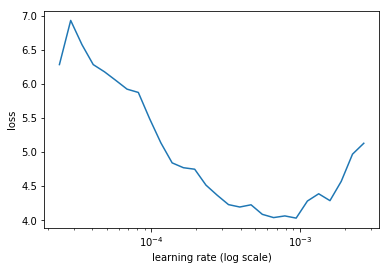

In [84]:
learn.lr_find()
learn.sched.plot(5)

This seems a good value given the graph above (right in the middle before it starts increasing wildly).

In [85]:
lr = 3e-4

In [86]:
lr

0.0003

In [87]:
learn.fit(lr, 2, cycle_len=5, cycle_mult=3)

epoch      trn_loss   val_loss                            
    0      3.665035   1.125584  
    1      1.441482   0.416248                            
    2      0.714701   0.42232                              
    3      0.566896   0.150175                             
    4      0.336936   0.146496                             
    5      1.493303   2.385499                             
    6      2.444785   1.943686                            
    7      1.26793    1.549484                            
    8      0.792268   1.505548                             
    9      0.880228   1.232999                             
    10     0.556619   0.720466                             
    11     0.300557   0.393681                             
    12     0.199768   0.311187                             
    13     0.122804   0.458304                             
    14     0.129854   0.524106                             
    15     0.093399   0.295495                              
    16    

[0.13517730682855472]

In [88]:
learn.save("transferred-" + VERSION)

In [89]:
learn.load("transferred-" + VERSION)

This went better when we added aug_tfms and brought in some more data.  What we ended up doing was just repeating our data substantially and hoped that aug_tfms would modify it enough to do some actual learning on - which it did.

One of the interesting things was it would tend to predict weights in 100s better than the 200s - since it had seen more of the 100s.

### Spot check to make sure all is well

In [90]:
x,y = md.val_dl.get_batch([11,12,13,14])

In [91]:
#x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

In [92]:
pred = random.randint(1,bs)

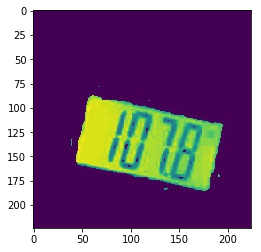

In [93]:
plt.imshow(md.val_ds.denorm(to_np(x))[pred])

In [94]:
preds[pred]

array([ 0.88139, -0.18406,  7.12622,  8.41085], dtype=float32)

In [95]:
[round(float(preds[pred][i])) for i in range(0,4)]

[1, 0, 7, 8]

So our model seems to be predicting that reasonably well (after rounding).  On to some real data!

In [108]:
test_path = "/src/data/digits/regression/1321_30.jpg"
test_path = "output.jpg"
im = open_image(test_path) # open_image() returns numpy.ndarray
#im = cv2.flip(im, 1)
#im = cv2.rotate(im, cv2.ROTATE_90_COUNTERCLOCKWISE)
#im = cv2.normalize(im, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
im = val_tfms(im)
#im = im.T


In [102]:

preds = learn.predict_array(im[None]);preds

array([[1.05663, 0.60754, 7.9119 , 7.61505]], dtype=float32)

In [103]:
im.T.shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


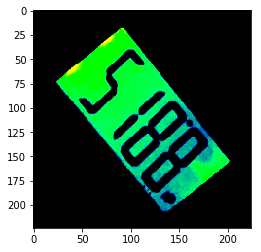

In [104]:
plt.imshow(im.T)

In [111]:
temp_preds = [round(float(preds[0][i])) for i in range(3,-1,-1)]
temp_preds.reverse()
temp_preds

[1, 1, 8, 8]

It's interesting - what I think has happened here is that the scale data that's been taught has so few examples of > 200, that the model assumes that the first digit will be 1 (despite it very obviously being a 2).

## Final Step : Deployment to Pipeline

#### Final Steps
-----------------
- We want to have online learning so the model can keep getting better.